# Tutorial for Event-Related Potential (ERP) computing

Authors: Daniel Falcon, Renato Paredes
Laboratorio de Neurociencia Cognitiva Computacional - Departamento de Psicología, Pontificia Universidad Católica del Perú

This tutorial is based on [MNE-Python](https://mne.tools/stable/auto_tutorials/index.html).

## Environment setup

In [ ]:
!pip install mne
!wget https://github.com/renatoparedes/Neuro-PUCP/blob/main/EEG/test3.csv

In [6]:
import mne
import numpy as np
import pandas as pd

In [2]:
def read_raw_csv(file_name, columns, sampling_freq):

    # Read data
    data = pd.read_csv(file_name, skiprows=1)

    # Select columns of interest in data
    selected_data = data[columns].copy()
    selected_data["MarkerValueInt"] = selected_data["MarkerValueInt"].fillna(0)
    selected_data["MarkerValueInt"] = selected_data["MarkerValueInt"].astype(int)

    # Get channel names
    col_names = selected_data.columns.values
    ch_names = []
    for name in col_names:
        if "EEG" in name:
            ch_names.append(name[4:])
        else:
            ch_names.append(name)

    # Specify channel types
    ch_types = ["eeg"] * (len(ch_names) - 1)
    ch_types.append("stim")

    # Creat MNE raw object
    sfreq = sampling_freq
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(selected_data.transpose(), info)

    return raw

## Load data

In [5]:
# Load data from columns of interest
columns = [
    "EEG.Cz",
    "EEG.Fz",
    "EEG.Fp1",
    "EEG.F3",
    "EEG.CP3",
    "EEG.O1",
    "EEG.Pz",
    "EEG.Oz",
    "EEG.O2",
    "EEG.CP4",
    "EEG.F4",
    "EEG.Fp2",
    "MarkerValueInt",
]
raw = read_raw_csv(file_name="test3.csv", columns=columns, sampling_freq=128)
raw.info

Creating RawArray with float64 data, n_channels=13, n_times=7842
    Range : 0 ... 7841 =      0.000 ...    61.258 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"12 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


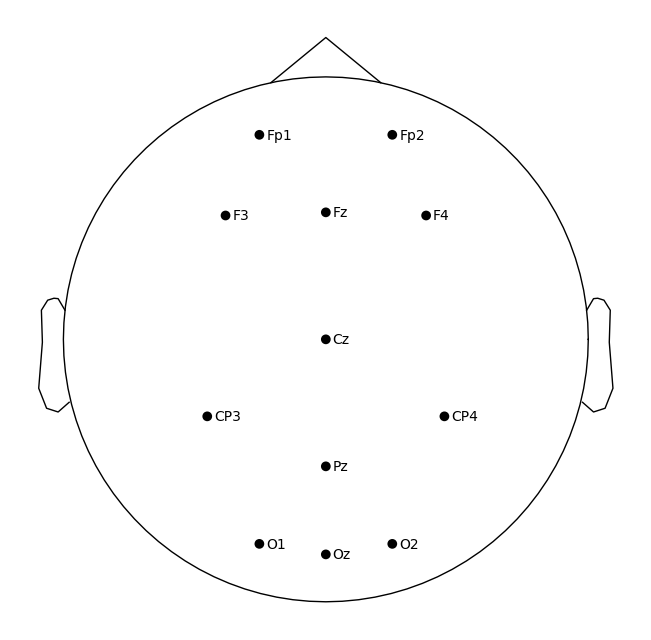

In [61]:
# Specify montage
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(easycap_montage)

# Show montage
fig = raw.plot_sensors(show_names=True)

## EEG data pre-processing

In [62]:
# All EEG data were first bandpass filtered from 0.1 to 30 Hz.
l_freq = 0.1
h_freq = 30
raw.filter(l_freq, h_freq)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 s)



/tmp/ipykernel_60132/3310133936.py:4: RuntimeWarning: filter_length (16501) is longer than the signal (7842), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq, h_freq)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,15 points
Good channels,"12 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [63]:
# Data were then re-referenced to the common average before continuing with paradigm-specific processing.
raw.set_eeg_reference("average")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,15 points
Good channels,"12 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [71]:
# We removed eye-blink artefacts using independent component analysis (ICA). See: https://mne.tools/stable/help/migrating.html
from mne.preprocessing import ICA

# Random state refers to SEED.
ica = ICA(n_components=5, max_iter="auto", random_state=97)
ica.fit(raw)

Fitting ICA to data using 12 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.2s.


/home/renato/.virtualenvs/eeg/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,1000 iterations on raw data (7842 samples)
ICA components,5
Available PCA components,12
Channel types,eeg
ICA components marked for exclusion,—


In [72]:
explained_var_ratio = ica.get_explained_variance_ratio(raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 0.9911077261728864


In [73]:
component_number = 0
explained_var_ratio = ica.get_explained_variance_ratio(
    raw, components=[component_number]
)

print(
    f"Fraction of variance explained by component #{component_number}:",
    explained_var_ratio["eeg"],
)

Fraction of variance explained by component #0: 0.47680098783132685


Creating RawArray with float64 data, n_channels=5, n_times=7842
    Range : 0 ... 7841 =      0.000 ...    15.682 secs
Ready.


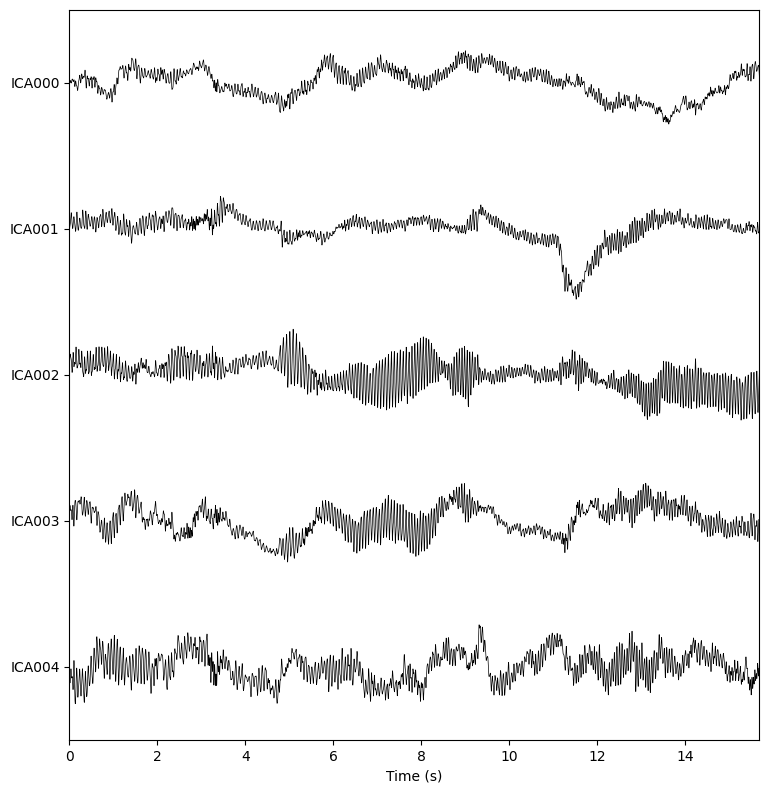

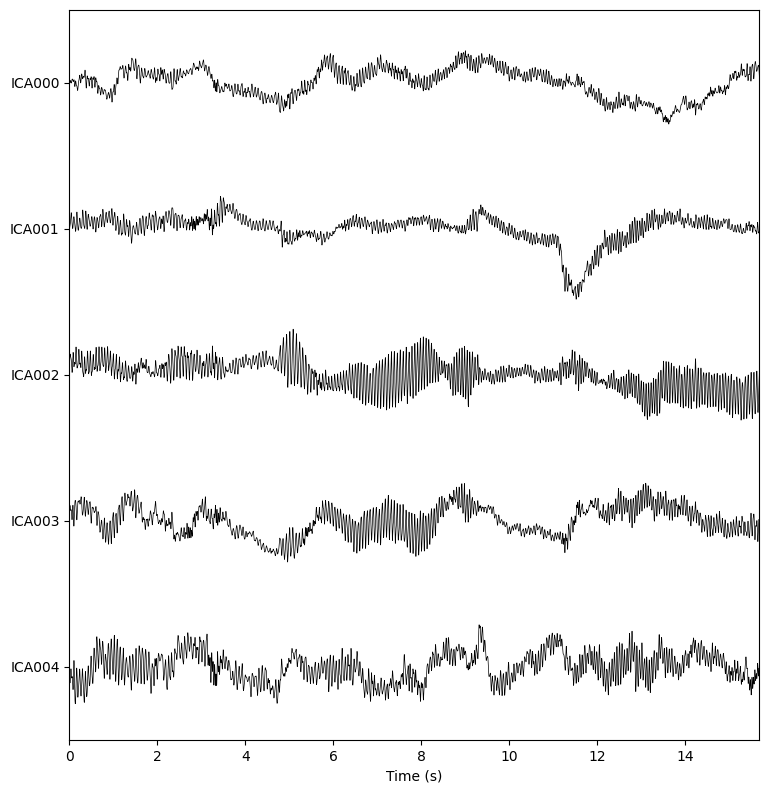

In [74]:
# Show indepedent components
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

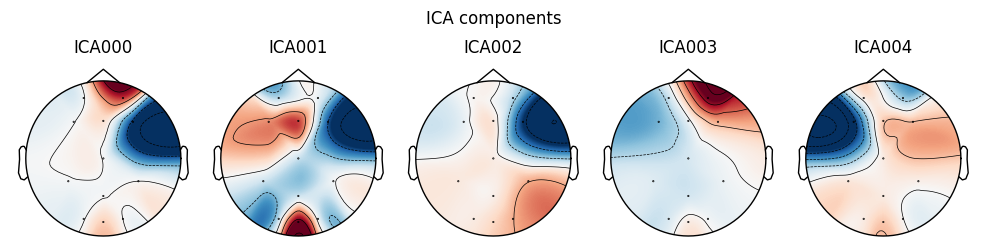

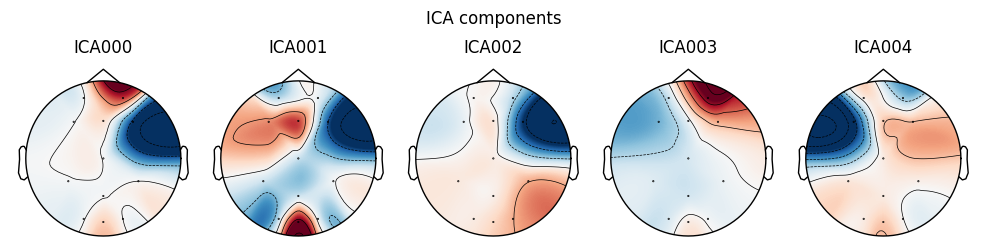

In [75]:
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated


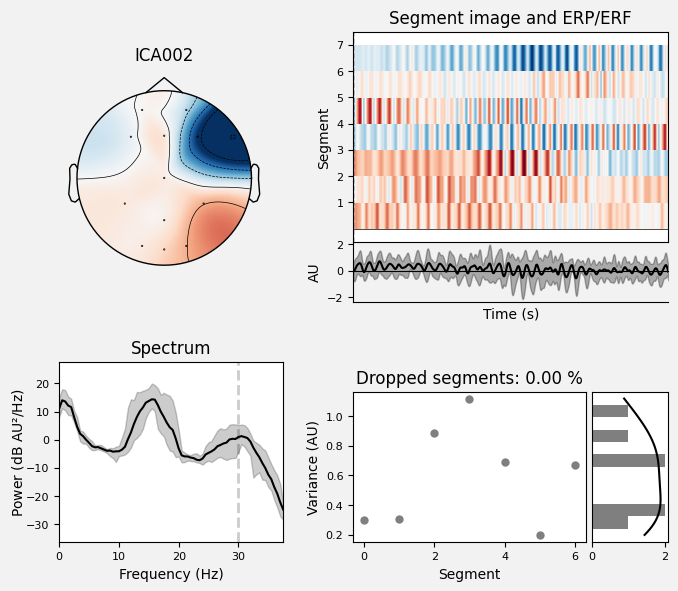

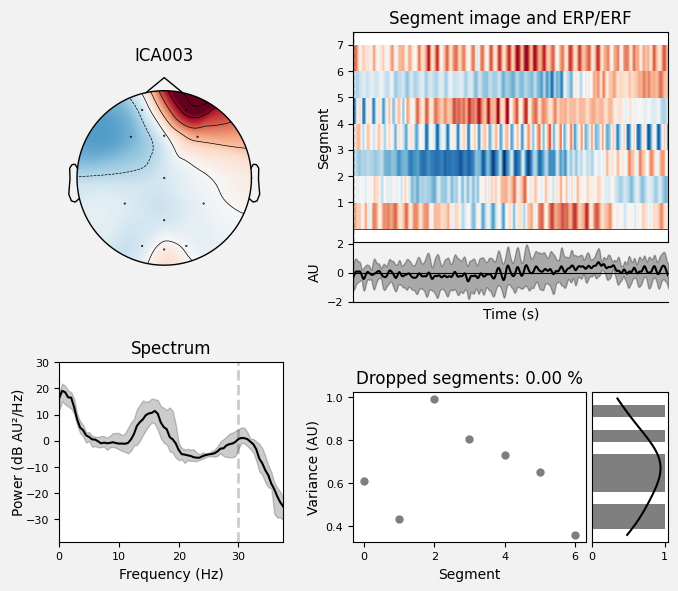

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [76]:
# Explore components of interest
ica.plot_properties(raw, picks=[2, 3])

A guide on how to identify artifact components from ICA: https://labeling.ucsd.edu/tutorial/labels

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 12 PCA components


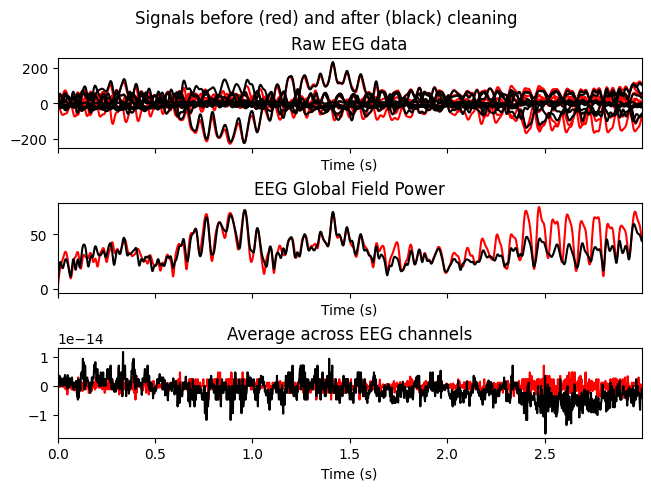

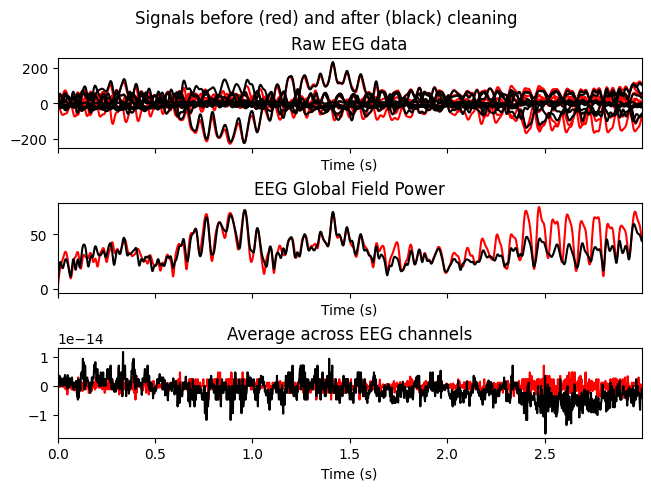

In [77]:
# Show EEG signals before and after removing a component
ica.plot_overlay(raw, exclude=[2], picks="eeg")

In [78]:
# Exclude the desired component
ica.exclude = [2]

In [79]:
# Reconstrct the signal after removing the desired component
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 12 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,15 points
Good channels,"12 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


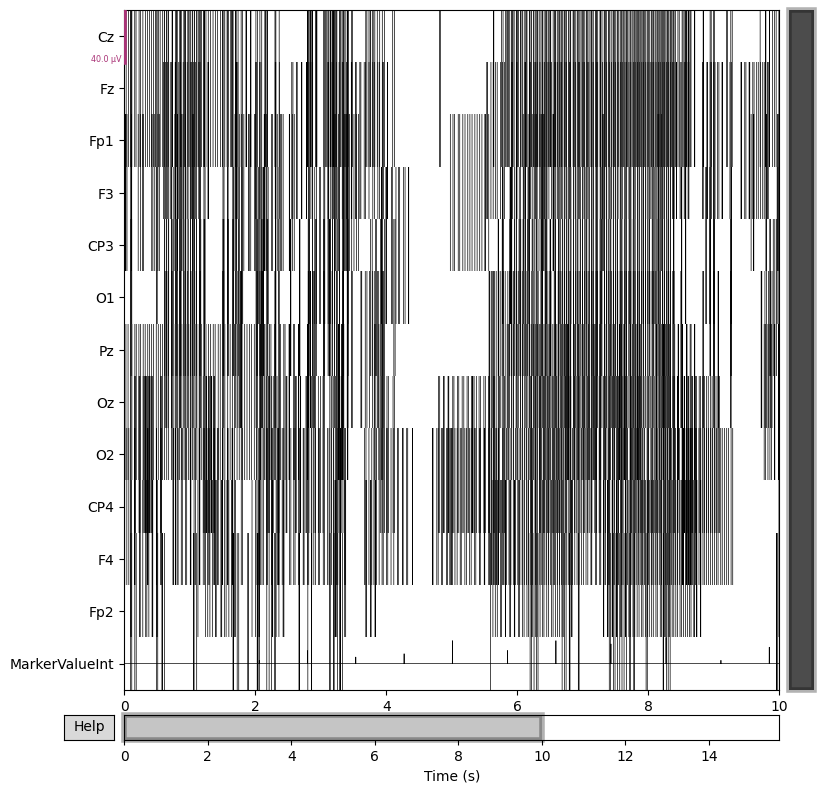

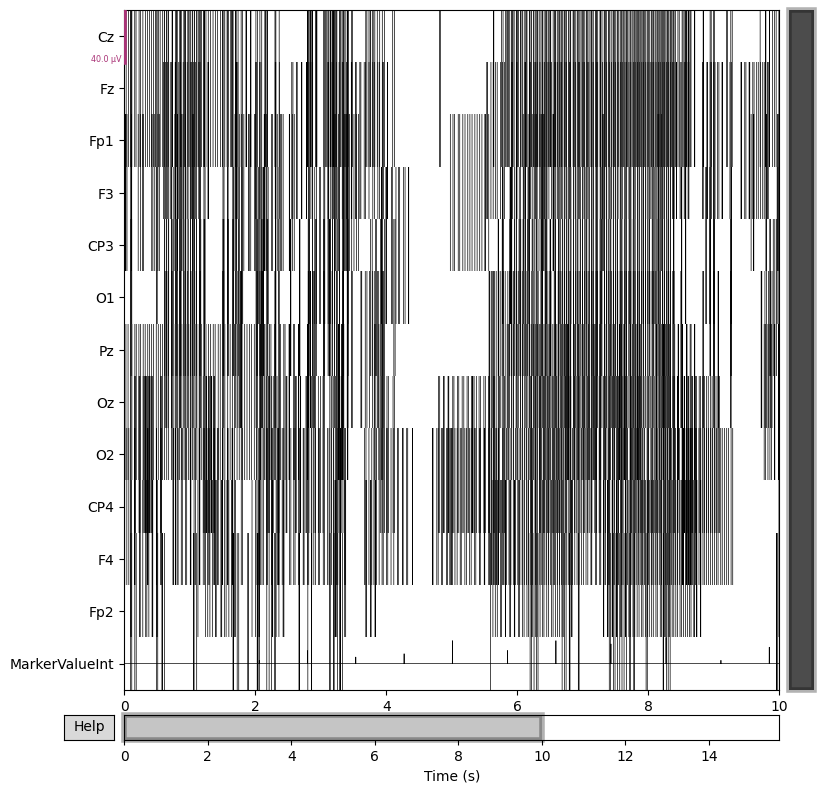

In [80]:
# Show reconstructed signal
reconst_raw.plot()

## Epoching

16 events found on stim channel MarkerValueInt
Event IDs: [1 2 3 4 5 6 7 8]


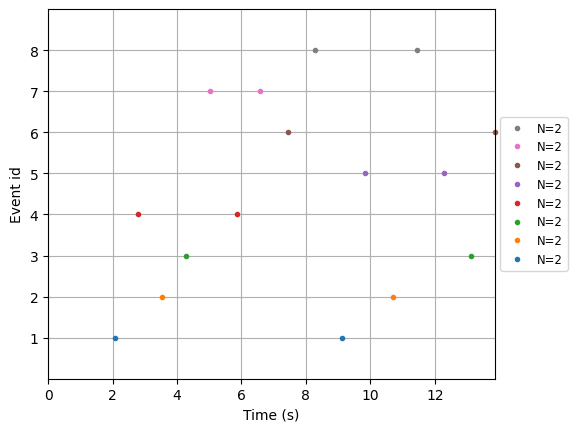

In [82]:
# Find events in the dataset
events = mne.find_events(reconst_raw)

# Plot events
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=reconst_raw.first_samp
)

In [87]:
# The pruned data were then epoched from −100 ms to 700 ms relative to stimulus onset.
# Each epoch was baseline corrected from −100 ms to 0 ms.
# Epochs with PTP amplitude values ±150 mV were excluded.

epochs = mne.Epochs(
    reconst_raw,
    events,
    tmin=-0.1,
    tmax=0.7,
    baseline=(-0.1, 0),
    reject=dict(eeg=150e-6),
)

Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [85]:
epochs.plot(n_epochs=86, events=True)

RuntimeError: epochs.plot() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.

## ERP calculation

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


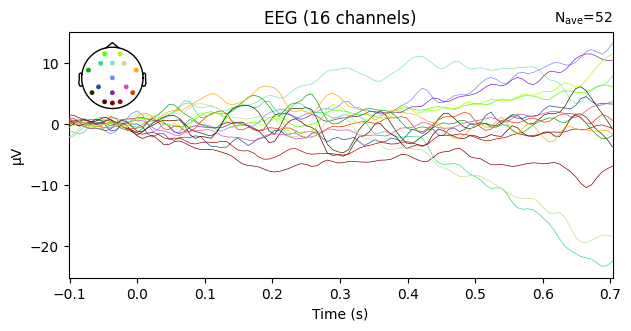

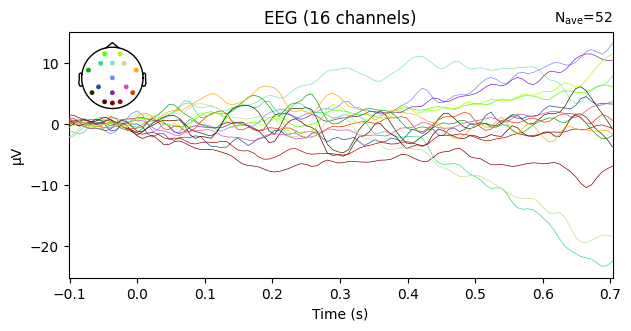

In [84]:
# We then averaged accepted epochs to create ERP waveforms for both standard and deviant tones.
evoked = epochs.average()
evoked.plot()

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


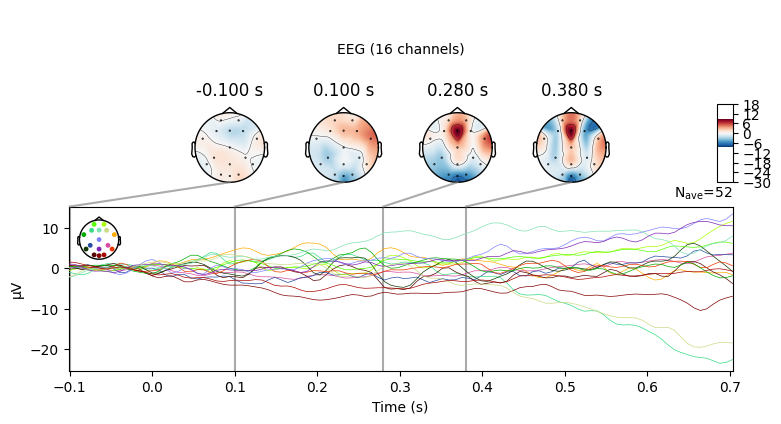

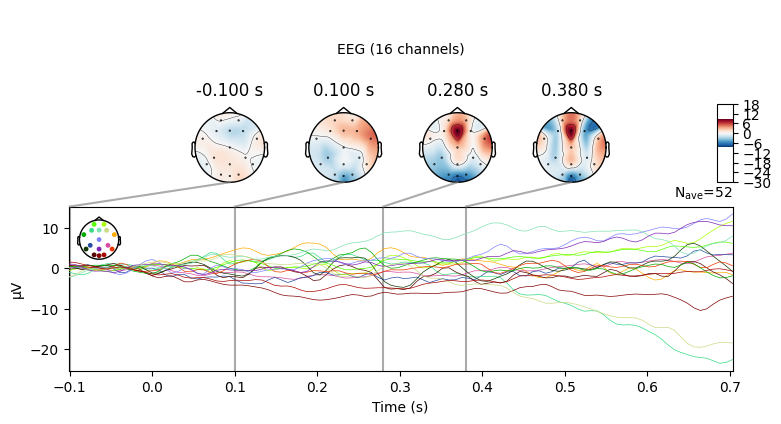

In [85]:
# Plot times of interest
evoked.plot_joint(times=[-0.1, 0.1, 0.28, 0.38])

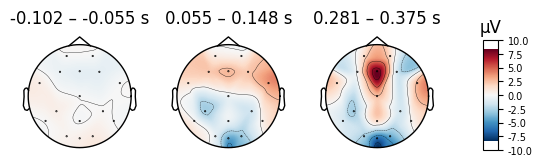

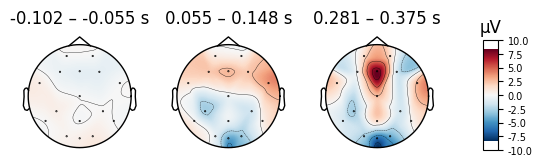

In [86]:
# Plot topographic map of times of interest
evoked.plot_topomap(times=[-0.1, 0.1, 0.33], average=0.1)

Not setting metadata
52 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_4578/773739861.py:2: RuntimeWarning: Only one channel in group "Fz"; cannot combine by method "mean".
  epochs.plot_image(picks="Fz", combine="mean")


combining channels using "mean"


/tmp/ipykernel_4578/773739861.py:2: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs.plot_image(picks="Fz", combine="mean")


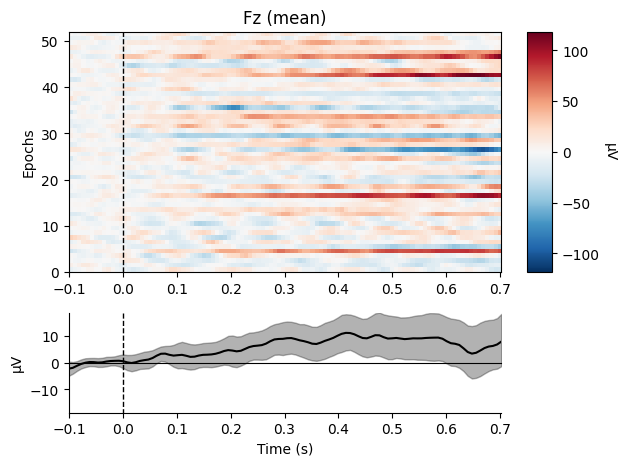

[<Figure size 640x480 with 3 Axes>]

In [87]:
# Plot ERP per channel
epochs.plot_image(picks="Fz", combine="mean")

In [83]:
# We calculated the P300 peak for each EEG system as the average waveform value over the pre-determined time window of 280–380 ms following stimulus onset.
epochs.load_data()
evoked_window = epochs.copy().average().crop(tmin=0.280, tmax=0.380)
evoked_channel = evoked_window.pick("Pz")
evoked_channel.get_peak(return_amplitude=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


('Pz', 0.34375, 2.076524283611792e-06)